# Import and Clean Data

In [585]:
import csv
import pkgutil
import encodings
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

def all_encodings():
    modnames = set([modname for importer, modname, ispkg in pkgutil.walk_packages(
        path=[os.path.dirname(encodings.__file__)], prefix='')])
    aliases = set(encodings.aliases.aliases.values())
    return modnames.union(aliases)

text = b'\x96'
for enc in all_encodings():
    try:
        msg = text.decode(enc)
    except Exception:
        continue
    if msg == 'ñ':
        print('Decoding {t} with {enc} is {m}'.format(t=text, enc=enc, m=msg))


Decoding b'\x96' with mac_farsi is ñ
Decoding b'\x96' with mac_arabic is ñ
Decoding b'\x96' with mac_iceland is ñ
Decoding b'\x96' with mac_turkish is ñ
Decoding b'\x96' with mac_romanian is ñ
Decoding b'\x96' with mac_roman is ñ
Decoding b'\x96' with mac_croatian is ñ


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: unicode_internal codec has been deprecated


In [586]:
df = pd.read_csv('Texas Last Statement - CSV.csv', encoding='latin1')

In [587]:
len(df)
# original df is 545 rows long.

545

In [588]:
a = df[df['LastStatement'].str.contains("innocent|didn't do|did not do|truth|not guilty|didn't kill|did not kill|did not murder|never killed|innocence")]
# create new dataframe "a" containing innocent last words
# len of a is 68

In [589]:
a = pd.get_dummies(a, prefix='Race', columns=['Race'])

In [590]:
a['Guilty'] = 0
df['Guilty'] = 1
# add column called Guilty to a with values 0.

In [350]:
df = pd.get_dummies(df, prefix='Race', columns=['Race'])


In [351]:
result.columns


Index(['Age', 'AgeWhenReceived', 'BlackVictim', 'Codefendants',
       'CountyOfConviction', 'EducationLevel', 'Execution', 'FemaleVictim',
       'FirstName', 'Guilty', 'HispanicVictim', 'LastName', 'LastStatement',
       'MaleVictim', 'NativeCounty ', 'NumberVictim', 'PreviousCrime',
       'Race_Black', 'Race_Hispanic', 'Race_White', 'TDCJNumber',
       'VictimOther Races', 'WhiteVictim'],
      dtype='object')

In [352]:
frames = [df, a]
result = pd.concat(frames)
result.drop_duplicates(subset=['TDCJNumber'], keep='last', inplace=True)
result.drop('Race_Other', axis=1, inplace=True)  

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [353]:
result.dropna(inplace=True)


In [356]:
len(result)

383

# Visualize Class Imbalance

Guilty
0    54 
1    329
Name: Guilty, dtype: int64


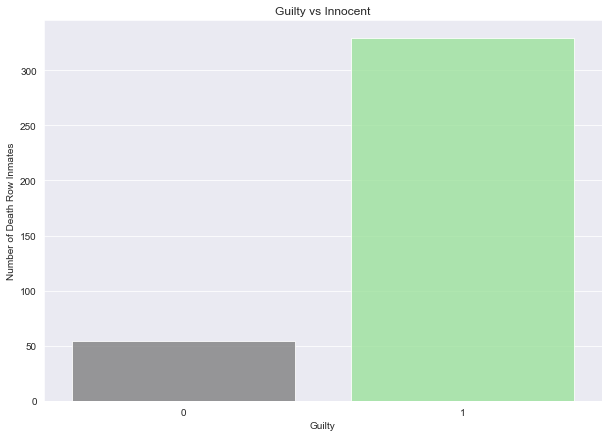

In [526]:
print(result.groupby(['Guilty']).Guilty.count())
sns.set_style('darkgrid')
plt.figure(figsize = (10,7))
sns.countplot(result['Guilty'], alpha =.8, palette= ['grey','lightgreen'])
plt.title('Guilty vs Innocent')
plt.ylabel('Number of Death Row Inmates')
plt.show()

# Train Test Split

In [753]:
from sklearn.model_selection import train_test_split

In [754]:
new_result = result.drop(['Execution','LastName', 'FirstName', 'TDCJNumber', 'CountyOfConviction', 'LastStatement', 'Guilty', 'Age', 'MaleVictim'], axis=1)

In [755]:
X = new_result
y = result['Guilty']

In [756]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

# Resample Using SMOTE, Create Decision Tree

In [670]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [689]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini',
 max_depth=4,
 min_samples_leaf=2,
 min_samples_split=10)
dtree.fit(X_resampled,y_resampled)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [672]:
predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

# 15% of innocent people were actually predicted not guilty using this model.
# 25% of not guilty were identified correctly.
# 91% of guilty people were actually predicted guilty using this model.
# 83% of guilty were identified correctly.

              precision    recall  f1-score   support

           0       0.07      0.17      0.10        12
           1       0.89      0.75      0.81       103

    accuracy                           0.69       115
   macro avg       0.48      0.46      0.46       115
weighted avg       0.80      0.69      0.74       115



In [673]:
predictions = dtree.predict(X_test)

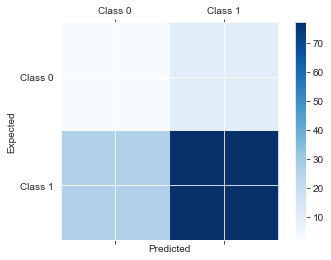

In [674]:
conf_mat = (confusion_matrix(y_test,predictions))
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()
# a confusion matrix 

In [675]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(X.columns)

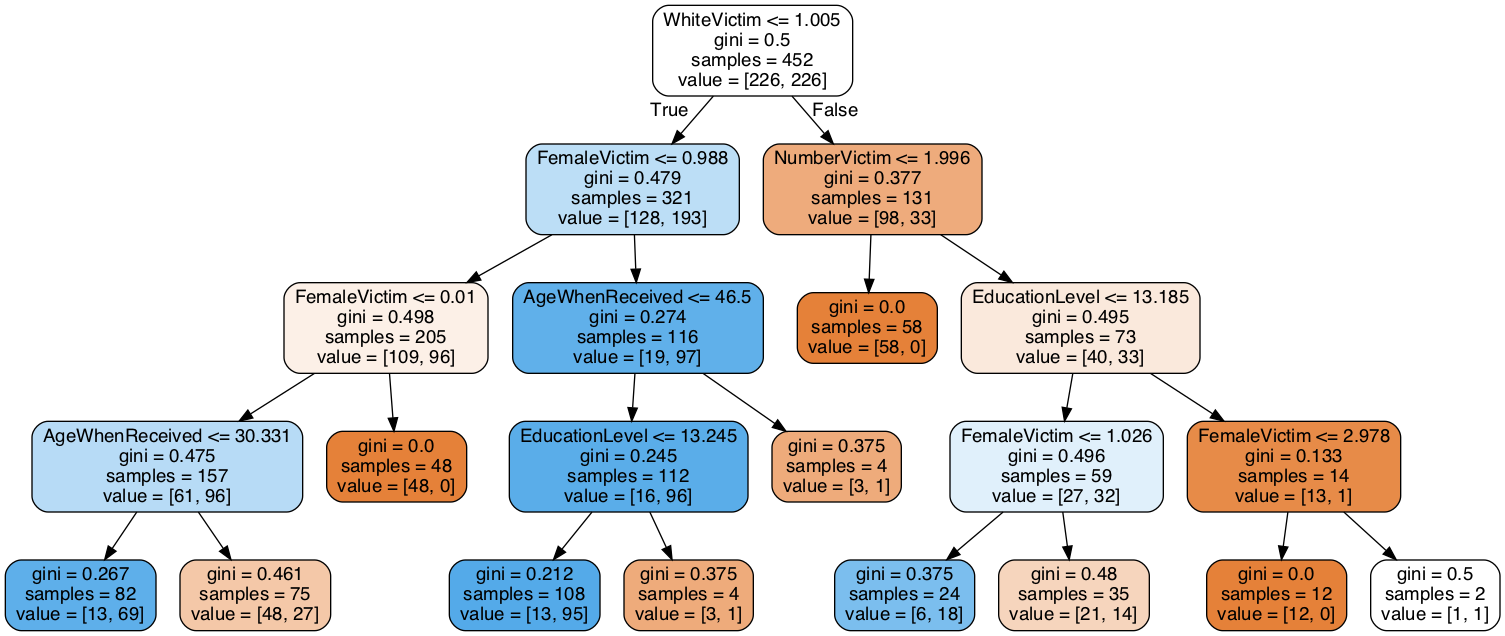

In [690]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

# Tune and Prune Tree Using Validation Curve

[-0.17021436614253047, -0.1714280315641692, -0.17604460815764789, -0.17890472148780123, -0.18279226873560597, -0.1843351992387445, -0.20291577419224596, -0.1967930154225256, -0.22907937852569868]


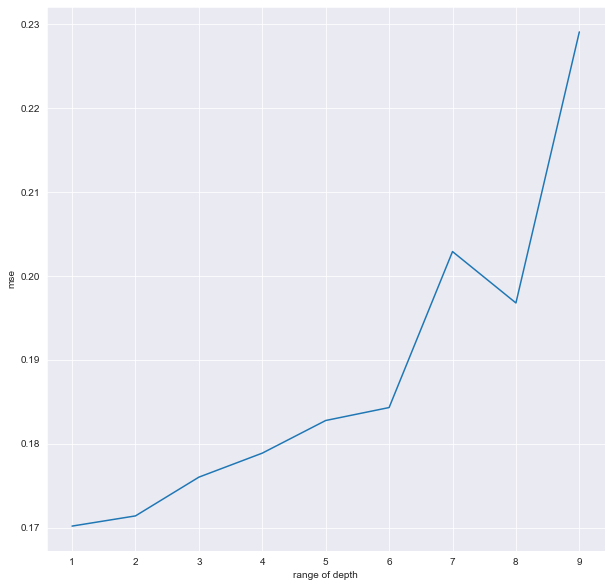

In [677]:
from sklearn.model_selection import cross_val_score
depth_range = range(1,10)
mse = []
for depth in depth_range:
    regtree = DecisionTreeRegressor(max_depth = depth)
    depth_score = cross_val_score(regtree, X, y, scoring = 'neg_mean_squared_error',cv = 6)
    mse.append(depth_score.mean())
print(mse)
mse = [abs(number) for number in mse]
plt.figure(figsize = (10,10))
plt.plot(depth_range, mse)
plt.xlabel('range of depth')
plt.ylabel('mse')
plt.show()

# GridSearch

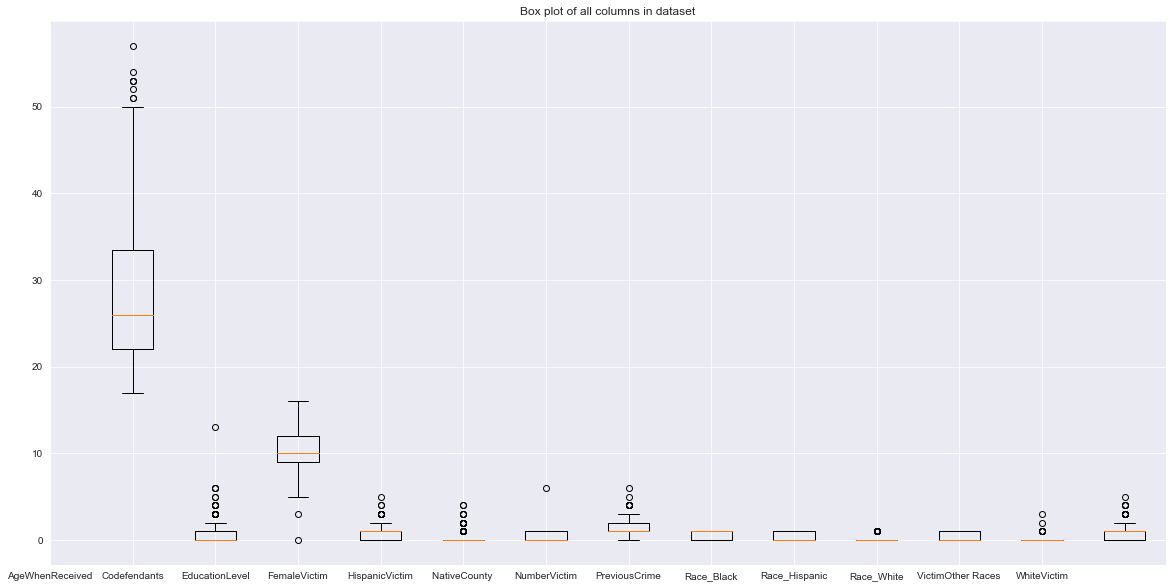

In [692]:
numerical_cols = result[['AgeWhenReceived',
 'Codefendants',
 'EducationLevel',
 'FemaleVictim',
 'HispanicVictim',
 'NativeCounty ',
 'NumberVictim',
 'PreviousCrime',
 'Race_Black',
 'Race_Hispanic',
 'Race_White',
 'VictimOther Races',
 'WhiteVictim']]
plt.figure(figsize=(20, 10))
plt.boxplot([numerical_cols[col] for col in numerical_cols.columns])
plt.title("Box plot of all columns in dataset")
plt.xticks(range(len(numerical_cols.columns.values)), numerical_cols.columns.values)
plt.show()

In [693]:
y = result['Guilty']
X = numerical_cols
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [680]:
dt_clf = DecisionTreeClassifier()

dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 72.12%


In [681]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}
clf = DecisionTreeClassifier()
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 4],
    'min_samples_split': [10, 20, 30, 40],
    'min_samples_leaf': [1, 2, 3, 4]
}


In [682]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [683]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_


Mean Training Score: 85.77%
Mean Test Score: 87.50%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [684]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [10, 20, 30, 40],
    'min_samples_leaf': [1, 2, 3, 4]
}

In [685]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Mean Cross Validation Score for Random Forest Classifier: 83.97%
Training Accuracy: 85.37%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}


In [686]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 85.37%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}


In [698]:
X.columns

Index(['AgeWhenReceived', 'BlackVictim', 'Codefendants', 'EducationLevel',
       'FemaleVictim', 'HispanicVictim', 'NativeCounty ', 'NumberVictim',
       'PreviousCrime', 'Race_Black', 'Race_Hispanic', 'Race_White',
       'VictimOther Races', 'WhiteVictim'],
      dtype='object')

# Feature Importance

In [700]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(11,'Score'))  #print 10 best features

                Specs     Score
13  WhiteVictim        7.213729
0   AgeWhenReceived    4.459612
10  Race_Hispanic      3.168072
5   HispanicVictim     2.528992
12  VictimOther Races  1.641337
6   NativeCounty       1.381020
8   PreviousCrime      0.806269
1   BlackVictim        0.726462
11  Race_White         0.652958
3   EducationLevel     0.621278
7   NumberVictim       0.343038


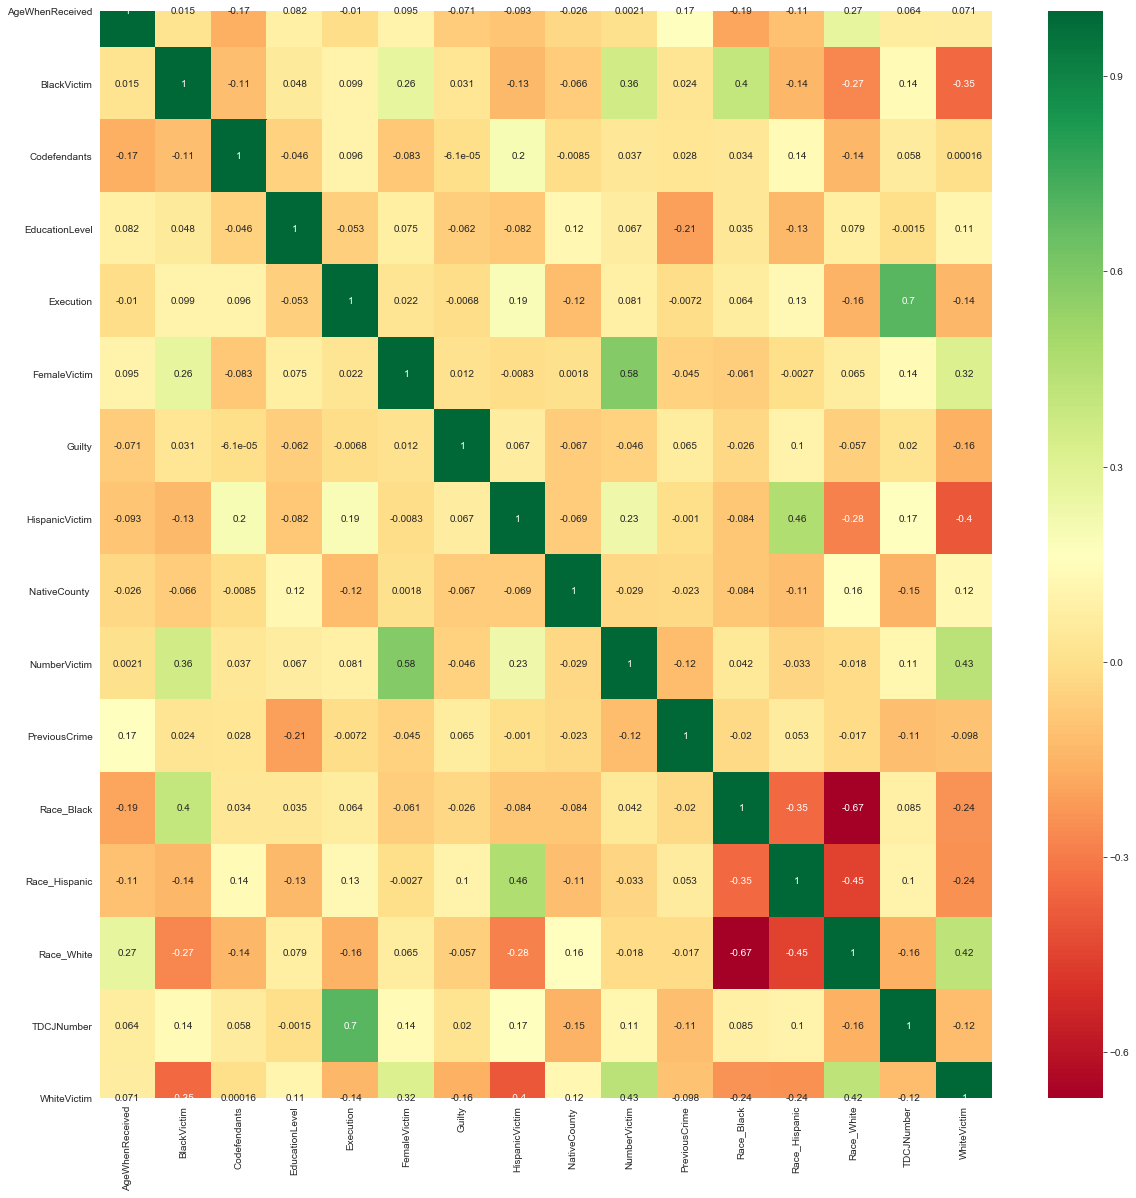

In [658]:
#get correlations of each features in dataset
data = result[['AgeWhenReceived', 'BlackVictim', 'Codefendants',
       'CountyOfConviction', 'EducationLevel', 'Execution', 'FemaleVictim',
       'FirstName', 'Guilty', 'HispanicVictim', 'LastName', 'LastStatement',
        'NativeCounty ', 'NumberVictim', 'PreviousCrime',
       'Race_Black', 'Race_Hispanic', 'Race_White', 'TDCJNumber',
       'WhiteVictim']]
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [659]:
pos_corr = corrmat[corrmat['Guilty'] > 0]
neg_corr = corrmat[corrmat['Guilty'] < 0]

In [660]:
pos_corr['Guilty'].sort_values(ascending=False)

Guilty            1.000000
Race_Hispanic     0.101092
HispanicVictim    0.067073
PreviousCrime     0.065314
BlackVictim       0.031077
TDCJNumber        0.019779
FemaleVictim      0.011829
Name: Guilty, dtype: float64

In [661]:
neg = neg_corr['Guilty'].sort_values(ascending=True)

In [662]:
neg

WhiteVictim       -0.156095
AgeWhenReceived   -0.070505
NativeCounty      -0.066625
EducationLevel    -0.062124
Race_White        -0.056575
NumberVictim      -0.046472
Race_Black        -0.026476
Execution         -0.006805
Codefendants      -0.000061
Name: Guilty, dtype: float64

In [633]:
dtree.feature_importances_

array([0.15371344, 0.        , 0.        , 0.02629814, 0.46380451,
       0.        , 0.        , 0.14036869, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.21581522])

In [634]:
['AgeWhenReceived',
 'BlackVictim',
 'Codefendants',
 'EducationLevel',
 'FemaleVictim',
 'HispanicVictim',
 'NativeCounty ',
 'NumberVictim',
 'PreviousCrime',
 'Race_Black',
 'Race_Hispanic',
 'Race_White',
 'VictimOther Races',
 'WhiteVictim']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# ADA Boost

In [701]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [734]:
mean = X['AgeWhenReceived'].mean()
std = X['AgeWhenReceived'].std()

In [736]:
z_scores = []
for i in X['AgeWhenReceived']:
    z_score = (i - mean)/std
    z_scores.append(z_score)

In [738]:
X['AgeWhenReceived'] = z_scores

In [748]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [749]:
clf.feature_importances_

array([0.45, 0.08, 0.04, 0.22, 0.04, 0.03, 0.02, 0.02, 0.02, 0.01, 0.02,
       0.02, 0.01, 0.02])

In [750]:
clf.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([0])

In [747]:
clf.score(X, y)

0.8825065274151436

In [763]:
predictions = clf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.50      0.08      0.14        12
           1       0.90      0.99      0.94       103

    accuracy                           0.90       115
   macro avg       0.70      0.54      0.54       115
weighted avg       0.86      0.90      0.86       115



# K Nearest Neighbors

In [766]:
from scipy.spatial.distance import euclidean
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)
clf = KNeighborsClassifier()
clf.fit(scaled_data_train, y_train)
test_preds = clf.predict(scaled_data_test)
print(precision_score(y_test, test_preds,pos_label='positive',average='micro'))
print(recall_score(y_test, test_preds,pos_label='positive',average='micro'))
print(accuracy_score(y_test, test_preds))
print(f1_score(y_test, test_preds, average='weighted'))

0.8782608695652174
0.8782608695652174
0.8782608695652174
0.8376006441223832


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [773]:
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test)
print(confusion_matrix(y_test, y_predict, labels=None, sample_weight=None))
print(classification_report(y_test, y_predict))

[[  0  12]
 [  0 103]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.90      1.00      0.94       103

    accuracy                           0.90       115
   macro avg       0.45      0.50      0.47       115
weighted avg       0.80      0.90      0.85       115



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
